# Final


In [1]:
%pylab inline 
import numpy.linalg as LA

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


Fill in your name in the cell below:

In [2]:
# Replace your own name
NAME = 'Gabrielle Giacoppe'
print('My name is ' + NAME )

My name is Gabrielle Giacoppe


## Final Guideline
- The deadline is **Dec 8th 10:30am**. Submission after the deadline will not be graded. 

- Submit your work(your reasoning and your code) as a SINGLE .ipynb document. Please rename the document as _FINAL_YOURNAME.ipynb_ (for example, _Final_FELIX.ipynb_). You are responsible for checking that you have correctly submitted the correct document. If your code cannot run, you may receive NO point. 

- You only use the Python packages included in the following cell. You are not allowed to use other advanced package or modules unless you are permitted to. If you would like to implement certain algorithms, you have to implement them from scratch. 

- In your final submission include the plots produced by the unedited code as presented below, as well as any additional plots produced after editing the code during the course of a problem. You may find it necessary to copy/paste relevant code into additional cells to accomplish this.

- Feel free to use the lecture notes and other resources but work on your own!



### Additional Guideline

- Your job in the final is to perform an analysis of these face image data sets. Your work will be assessed in two parts: **your algorithm performance (70pt)** and **your reasoning (30pt)**. 

- You can use any (and hopefully all) of the different **clustering** and **classification** methods discussed. Be sure to compare them against each other in these tasks.

- Your code should be efficient and finish all these tasks in reasonable running time. So you don't need to show me how you tune these hyper-parameters in your code. But you should mention your tuning process and results in your reasoning. 
If your code requires excessive time running, your score might be deducted up to 20%. 

- To give a bit more motivation, I will award bonus points to the top three final work. The winner receives 15pt, the runner up receives 10pt and the third place receives 5pt. I may also award special points for solutions of outstanding elegance.   

- (Optional, but strongly recommmended) I suggest you create a github account and upload your final work to a repository. When you submit your final to blackboard, please also include your  link to your github repository.  

In [3]:

# Load the faces datasets
lfw_people = fetch_lfw_people(min_faces_per_person=120, resize=0.4)

In [4]:
X = lfw_people.images

# the label to predict is the id of the person
y = lfw_people.target
# y values are 0, 1, 2, 3. Each corresponds to the following target names. 

target_names = lfw_people.target_names
print(target_names)
print(unique(y))

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Tony Blair']
[0 1 2 3]


In [5]:
# Split in training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.shape)
print(X_test.shape)

(773, 50, 37)
(258, 50, 37)


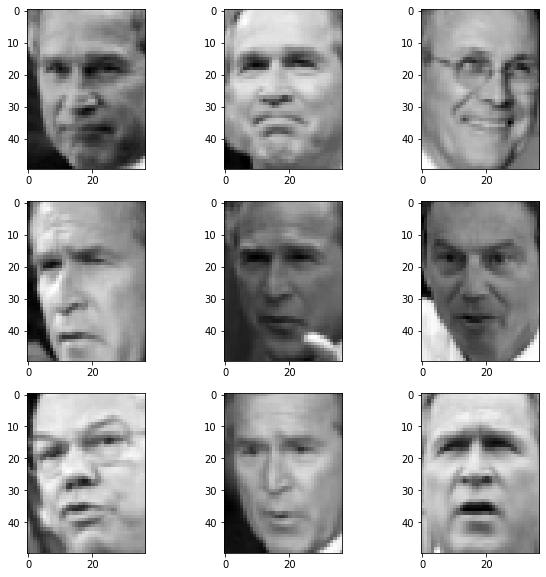

In [6]:
fig, axs = plt.subplots(3, 3,figsize=(10,10))
axs = axs.ravel()
for i in range(9):
    axs[i].imshow(X_train[i], cmap='gray')



---


# Task 1: Face Classification
Consider the various faces in the **training set** `(X_train, y_train)` and see if you can build a classifier that can reasonably identify an individual face in the **testing set** `(X_test, y_test)`. 

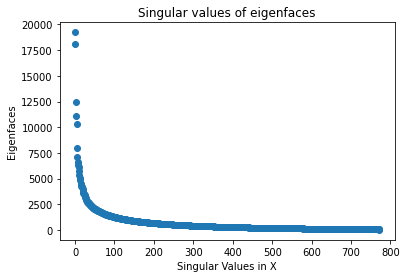

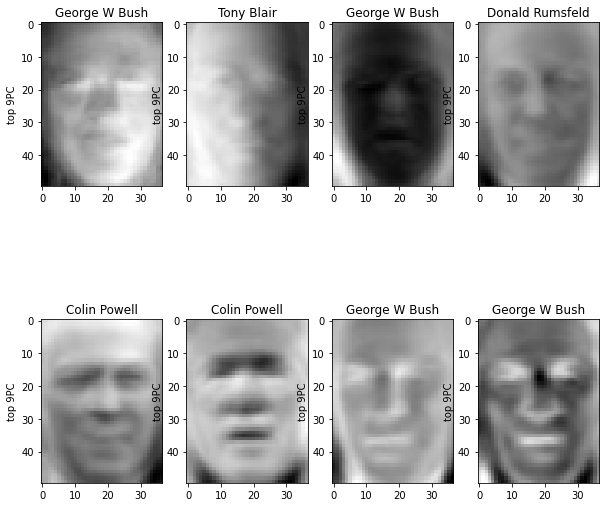

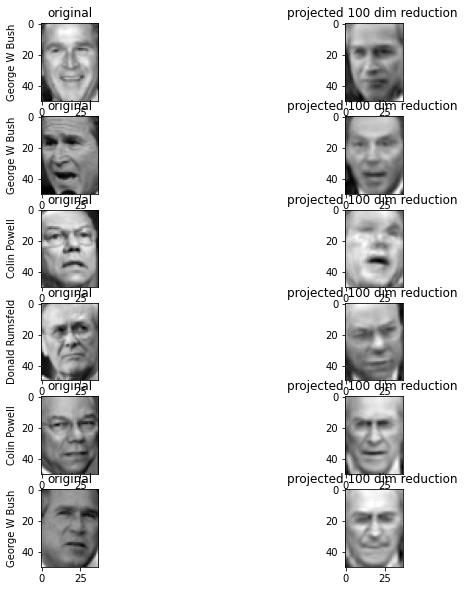

In [7]:
# your code for task 1 starts here
#@title Dimension reduction by performing PCA to reduce the dimension of raw face images. 

Xtrain  = reshape(X_train, [773, 1850])
Xtest  = reshape(X_test, [258, 1850])

# perform PCA to reduce dim
X_mean              = np.mean(Xtrain, axis=0)
X = Xtrain - X_mean
u, s, vh =svd(X, full_matrices=False)
V = vh.T
Z = dot(X, V[:,:248] )

Xtest_mean              = np.mean(Xtest, axis=0)
Xtest = Xtest -Xtest_mean
Ztest = dot(Xtest, V[:,:248])
scatter(arange(773), s);
plt.title("Singular values of eigenfaces"); plt.xlabel("Singular Values in X"); plt.ylabel("Eigenfaces")
PC = vh[:9,:] # top 9 PCs
PC_image = reshape(PC, [9, 50, 37]) # lets look at top 9 PC look like
fig, axs = plt.subplots(2, 4,figsize=(10,10))
axs = axs.ravel()
for i in range(8):
  axs[i].imshow(PC_image[i], cmap=pyplot.get_cmap('gray'))
  axs[i].title.set_text(target_names[y_test[i]])
  axs[i].set_ylabel('top 9PC')
  #print(PC[i])

#@title Choosing 100 from above scatterplot to reconstruct all 258.  
projected_X = dot(u[:,:100]*s[:100],vh[:100,:])+X_mean 
projected_Xte=reshape(projected_X , [773, 50,37])
fig, axs = plt.subplots(6, 2,figsize=(10,10))
axs = axs.ravel()
for i in range(6):
  axs[2*i].imshow(X_test[10*i], cmap=pyplot.get_cmap('gray')) #left one is the original picture
  axs[2*i+1].imshow(projected_Xte[10*i], cmap=pyplot.get_cmap('gray')) # right one is the approximated one with top 100 PC. 
  axs[2*i].set_ylabel(target_names[y_test[10*i]])
  axs[2*i].title.set_text('original')
  axs[2*i+1].title.set_text('projected 100 dim reduction ')

In [8]:
#@title Supervised Learning: SVM with Hinge Loss.

Xtr                   = X_train[0:773, :]
train_y_part          = y_train[0:773]
Ytr                   = zeros(train_y_part.size)
Xte                   = X_test[0:258,:]
test_y_part           = y_test[0:258]
Yte  = zeros(test_y_part.size)

Xtrain  = reshape(X_train, [773, 1850])
Xtest  = reshape(X_test, [258, 1850])

# perform PCA to reduce dim
X_mean              = np.mean(Xtrain, axis=0)
X = Xtrain - X_mean
u, s, vh =svd(X, full_matrices=False)
V = vh.T
Z = dot(X, V[:,:100] )

Xtest_mean          = np.mean(Xtest, axis=0)
Xtest = Xtest -Xtest_mean
Ztest = dot(Xtest, V[:,:100])

import time
start_time = time.time()
def predict(x, w, w0):
	activation = x.dot(w)+w0
	return activation

def train_weights_hinge(X, y, learning_rate_span,lambda_param, n_iter=1000):
  N,d = X.shape
  w   = np.random.random_sample(d)
  w0  = np.random.random_sample(1)

  for iter in range(n_iter):
    learning_rate = learning_rate_span[iter]
    arr = np.arange(N)
    random.shuffle(arr)
    for i in arr:
          condition = y[i] * (w.dot(X[i,:])+w0) >= 1
          if condition:
            w = w - learning_rate *  w

          else:
            w  = w - learning_rate * (w - lambda_param *y[i] * X[i,:] )
            w0 = w0 - learning_rate * ( -lambda_param * y[i] ) 

  return w, w0          

L=[10**-3, 10**-2]
errors = []
n_iter = 30
n_span = arange(n_iter)
learning_rate_span = 1/((1+ 2*n_span)**2)

for l in L:
  w,w0 = train_weights_hinge(Z, y, learning_rate_span, l, n_iter)
  ypred = predict(Ztest, w, w0) #test prediction
  for i in (y): #need to read this loop as if it is 0 colin if not 0 y can be 1,2,3
    if ypred[i]<1:
      ypred[ypred[i]==0]=0
    else: #y[i] !=0
      ypred[i] == 1 or ypred[i] ==2 or ypred[i] ==3
    if ypred[i]<2 and ypred[i]>0:
      ypred[ypred[i]==1]=1
    else: #y[i] !=1:
      ypred[i] ==0 or ypred[i]== 2 or ypred[i] == 3
    if ypred[i]<3 and ypred[i]>1:
      ypred[ypred[i]==2]=2
    else: 
      ypred[i]==3 or ypred[i]==1  or ypred[i] ==0
    if ypred[i]>2:
       ypred[ypred[i]==3]=3
    else: 
      ypred[i]==2 or ypred[i]==1  or ypred[i] ==0
  
  test_error = norm(ypred-y_test,0)/10000
  errors.append(test_error)
  print('For lambda =',l, 'test error is', test_error)
print("--- Test Error Rate for SVM Hinge is %s seconds ---" % (time.time() - start_time))

For lambda = 0.001 test error is 0.0258
For lambda = 0.01 test error is 0.0258
--- Test Error Rate for SVM Hinge is 0.976858377456665 seconds ---


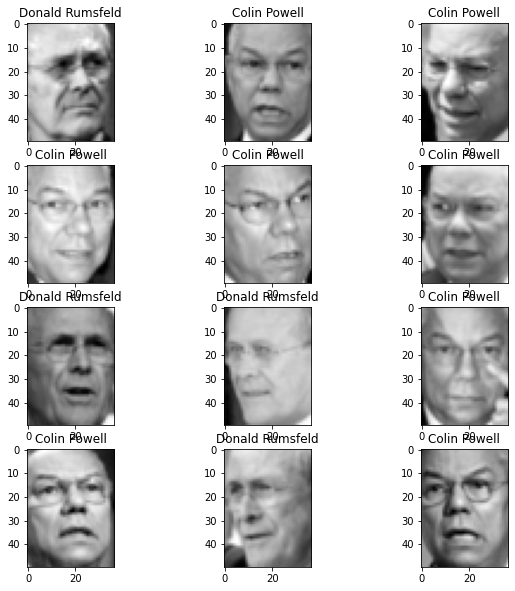

In [9]:
#@title Classified faces between Colin Powell and Donald Rumsfeld
fig, axs = plt.subplots(4, 3,figsize=(10,10))
axs = axs.ravel()
#index = where(y_test - ypred!=0)[0]
index_for_01 = where(ypred > y_test)[0]
for i in range(12):
  axs[i].imshow(X_test[index_for_01[i]], cmap=pyplot.get_cmap('gray'))
  axs[i].title.set_text(target_names[y_test[index_for_01[i]]]) 


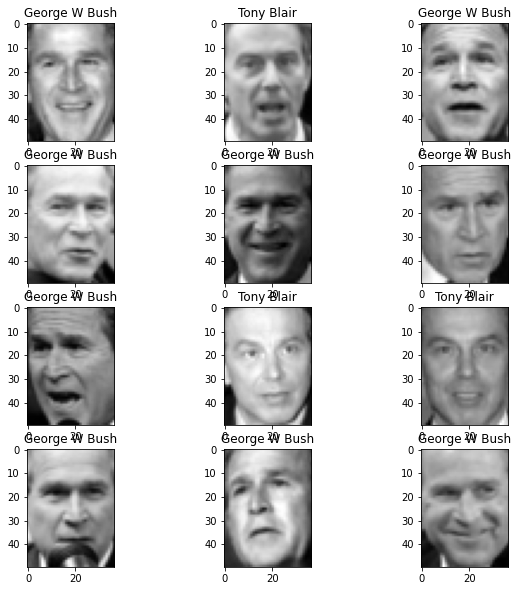

In [10]:
#@title Classified faces between George W Bush and Tony Blair
fig, axs = plt.subplots(4, 3,figsize=(10,10))
axs = axs.ravel()
index_for_23 = where(ypred < y_test)[0]
for i in range(12):
  axs[i].imshow(X_test[index_for_23[i]], cmap=pyplot.get_cmap('gray'))
  axs[i].title.set_text(target_names[y_test[index_for_23[i]]]) 

Text(0.5, 1.0, '5-fold cross validation')

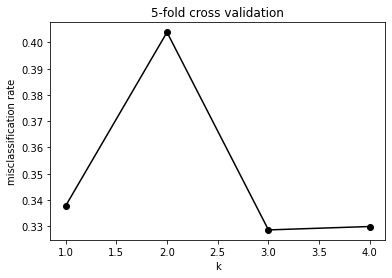

In [11]:
 #@title 5-fold cross validation on training dataset,k range from 1 to 5. For each k, estimate avg. misclassification rate with plot of the average misclassification rate verses k.
Xtrain  = reshape(X_train, [773, 1850])
Xtrain =Xtrain[3:]
y_train =y_train[3:]
Xtest  = reshape(X_test, [258, 1850])

# perform PCA to reduce dim
X_mean              = np.mean(Xtrain, axis=0)
X = Xtrain - X_mean
u, s, vh =svd(X, full_matrices=False)
V = vh.T
Z = dot(X, V[:,:250] )

Xtest_mean              = np.mean(Xtest, axis=0)
Xtest = Xtest -Xtest_mean
Ztest = dot(Xtest, V[:,:250])

 def myknn_predict(k, x_train, y_train, x_test):
  labelEst = np.zeros(x_test.shape[0])
  for i, x in enumerate(x_test):
    dist            = norm(x_train - x, axis=1)
    dist_sort_index = argsort(dist)
    neigh_labels    = y_train[dist_sort_index[0:k]]
    labelEst[i]     = argmax(bincount(neigh_labels))
  return labelEst

ks         = arange(1,5,1)
scores     = []
CV         = 5
N_train    = y_train.shape[0]
batch      = N_train/CV
for k in ks:
  x_train_CV = split(Z, CV)
  y_train_CV = split(y_train, CV)
  test_errs  = []
  for i in range(CV):
    index = delete(arange(CV),i)
    x_train_CV_i = vstack([x_train_CV[j] for j in index])
    y_train_CV_i = hstack([y_train_CV[j] for j in index])
    x_test_CV_i  = x_train_CV[i]
    y_test_CV_i  = y_train_CV[i]

    y_test_CV_i_predicted = myknn_predict(k, x_train_CV_i, y_train_CV_i, x_test_CV_i)
    test_errs.append(norm(y_test_CV_i_predicted - y_test_CV_i, 0)/batch)

  scores.append(mean(test_errs))  
plt.figure()
plt.plot(ks, scores, 'ko-')
plt.xlabel('k'); plt.ylabel('misclassification rate'); plt.title('5-fold cross validation')

In [12]:
optk = ks[argmin(scores)]
print('The optimal k is ', optk)
N_test = y_test.shape[0]
y_test_predicted  = myknn_predict(optk, Z, y_train, Ztest)
opt_test_err = norm(y_test_predicted - y_test, 0)/N_test
print('The optimal test error is' , opt_test_err)

The optimal k is  3
The optimal test error is 0.3023255813953488


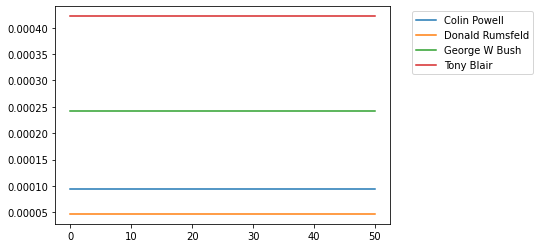

In [13]:
#@title LASSO test  plot the regularization path of coefficients vs the λ for each unique y label. 
def lasso(X, y, l1, tol=1e-6):
  m, n      = np.shape(X)
  q, r      = linalg.qr(X);
  w_s       = linalg.solve(r, q.T.dot(y))
  iter   = 0
  while True:
      w_star = w_s.copy()
      for j in range(n):
         a_j     = LA.norm(X[:, j])**2
         index   = arange(n)
         index_d = delete(index, j)
         c_j     = np.dot(X[:,j].T, y-np.dot(X[:,index_d],w_s[index_d]))
         update  = c_j/a_j
         w_s[j]  = np.sign(update) * max(abs(update) - l1/a_j, 0)   
        
      iter += 1
      if np.all(abs(w_s - w_star) < tol):
        #print('Number of iteration is ', iter)
        break

  return w_s
w=lasso(Z,y_train,4,tol=1e-06)
#plot lasso path
l_span   = linspace(0,50,100)
w4_store = zeros((100, 250))

for index in range(len(l_span)):
  l         = l_span[index]
  w=lasso(Z,y_train,4,tol=1e-06)
  w4_store[index,:]=w.T

fig, ax = plt.subplots()
for index in range(4):
  ax.plot(l_span, w4_store[:,index+1],'-',label= f'{target_names[index]}')
leg = ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

# **Your Answer:**

1. Test Error Rate for SVM Hinge is 0.88 seconds.
2. When SVM with Hinge loss is run for lambda = 0.001 the test error was 0.0258 and lambda = 0.01 test error was 0.0258.
3. 5-fold Cross validation estimated optimal k=3, and optimal test error 0.302325.



---

# Task 2: Unsupervised Learning

In an unsupervised way, can you develop algorithms that automatically find patterns in the faces that naturally cluster in the **training set** `(X_train)`? You may use **testing set** `(X_test, y_test)` to test your performance. 

In [14]:
#@title Gaussian mixture models over loop for an increasing K from (1,6)
n_clusters = len(unique(y_train))
print('There will be', n_clusters, 'clusters in GMM') 

Xtrain  = reshape(X_train, [773, 1850])
Xtest  = reshape(X_test, [258, 1850])

# perform PCA to reduce dim
X_mean              = np.mean(Xtrain, axis=0)
X = Xtrain - X_mean
u, s, vh =svd(X, full_matrices=False)
V = vh.T
Z = dot(X, V[:,:4] )

Xtest_mean              = np.mean(Xtest, axis=0)
Xtest = Xtest -Xtest_mean
Ztest = dot(Xtest, V[:,:4])



def log_likelihood(X,K,Pi_opt,Mu_opt, Sigma_opt):
  N,d = X.shape
  likelihood = zeros((N,K))
  for i in range(N):
    for k in range(K):
      x_m = X[i,:]-Mu_opt[k]
      covariance = Sigma_opt[k]
      pdf = (1. / (sqrt((2 * pi)**d * det(covariance))) * 
            exp(-(solve(covariance, x_m.T).T.dot(x_m.T)) / 2))
      likelihood[i,k] = pdf * Pi_opt[k]
  log_ell = sum(log(sum(likelihood, axis=1)))
  return log_ell

def BIC(K,d,N,log_ell_hat):
  return (K-1+K*d+K*d*(d+1)/2)*np.log(N)-log_ell_hat

def euclidean_distance(x1, x2):
    return sqrt(sum((x1 - x2) ** 2))
    
# initialization for Kmeans++ algorithm
def initialization(X, K):
    
    ## Step 1: initialize the centroids list and add
    ## a randomly selected data point to the list
    n_samples, n_features = X.shape
    random_sample_idxs = random.choice(n_samples, 1, replace=False)
    centroids = X[random_sample_idxs,:]

    ## compute remaining K - 1 centroids
    for c_id in range(K - 1):
        ## Step 2: initialize a list to store distances of data
        ## points from nearest centroid 
        ## compute distance of 'point' from each of the previously
        ## selected centroid and store the minimum distance
        dist = zeros(n_samples)
        for idx, sample in enumerate(X):
          distances     = [euclidean_distance(sample, point) for point in centroids]
          dist[idx]     = min(distances)

        ## Step 3: select data point with maximum distance as our next centroid  
        next_centroid = X[argmax(dist), :]
        centroids=vstack([centroids,next_centroid])

    return centroids

def initialize(X, K, centroids):
    # N has the number of rows while d has the number of columns of dataset X 
    N, d = X.shape 

    # initial weights given to each cluster are stored in phi or P(Ci=j)
    Pi = full(shape=K, fill_value=1/K) 

    # initial weights given to each data point wrt to each cluster or P(Xi|Zi=j)
    weights = full(shape=(N,d), fill_value=1/K)
        

    # initial value of mean of K Gaussians 
    Mu = [  centroids[i,:] for i in range(K) ] 
    # initial value of covariance matrix of K Gaussians
    Sigma = [ cov(X.T) for _ in range(K) ] 
    # theta =(Mu,Sigma,Pi)
    return Pi, Mu, Sigma, weights

# multivariate normal distribution for one instance and multiple features
def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m.T).T.dot(x_m.T)) / 2))

# computer posterior probability of each data point wrt each cluster
# parameters are Pi, Mu, Sigma
def predict_posterior(X, K, Pi, Mu, Sigma):
    N,d = X.shape
    # Creates a N*K matrix denoting probability of each point wrt each cluster 
    likelihood = zeros( (N, K) )
    for i in range(K):
      for j in range(N):
        distribution = multivariate_normal(X[j,:], d, Mu[i], Sigma[i])
            # pdf : probability denisty function
        likelihood[j,i] = distribution * Pi[i]
    numerator = likelihood
    denominator = numerator.sum(axis=1)[:, np.newaxis]
    weights = numerator / denominator
    return weights


# E-Step: update weights holding Pi Mu Sigma constant
def e_step(X, K, Pi, Mu, Sigma):
    # updated weights(i,c)=P(Zi=c|Xi)
    weights   = predict_posterior(X, K, Pi, Mu, Sigma)
    return weights


# M-Step: update Mu, Sigma, Pi, holding weights constant
def m_step(X, K, weights):
    # mean of sum of probability of all data points wrt to one cluster is new updated probability of cluster Pi_c
    Pi_update = weights.mean(axis=0)  
    Mu_update = [[] for _ in range(K)]
    Sigma_update = [[] for _ in range(K)]
    for i in range(K):
        weight_i = weights[:, [i]]
        total_weight = weight_i.sum()
        Mu_update[i]    = (X * weight_i).sum(axis=0) / total_weight
        Sigma_update[i] = cov(X.T, aweights=(weight_i/total_weight).flatten(), bias=True)  

    return Pi_update, Mu_update, Sigma_update    
    
# predict function 
def predict(X, K, Pi, Mu, Sigma):
   weights = predict_posterior(X, K, Pi, Mu, Sigma)
   # datapoint belongs to cluster with maximum probability
   # returns this value
   return argmax(weights, axis=1)

def GMM_fit(X, K,centroids, max_iter=100, threshold =0.001):
  # initialise parameters like weights, Pi, Mu, Sigma of all Gaussians in dataset X
  #step 1
  Pi, Mu, Sigma, weights = initialize(X,K,centroids)
  for j in range(max_iter):
    z = predict(X, K, Pi, Mu, Sigma)
    Mu_array = array(Mu)
    
    # Step 2 iterate to update the value of P(Xi/zi=j)
    weights = e_step(X, K, Pi, Mu, Sigma)
    Pi_old  = Pi;
    Mu_old  = Mu;
    # Step 3 iterate to update the value of Mu, Sigma and Pi as the clusters shift
    Pi, Mu, Sigma  = m_step(X, K, weights)

  # for stopping
    distances = [ norm(Mu[i] - Mu_old[i]) for i in range(K)] 
    print(sum(distances))
    if sum(distances) < threshold:
      print('Number of iteration is ', j+1)
      break

  z = predict(X, K, Pi, Mu, Sigma)
  Mu_array = array(Mu)
  

  return z, Pi, Mu, Sigma 

There will be 4 clusters in GMM


822.5000681254409
0.0
Number of iteration is  2
2014.3483385554764
63.76188242297651
41.122963101761094
31.27806719614003
26.63664745211633
24.53821058791367
23.98992313988033
24.739253323249983
26.819367594763364
30.325642979056646
35.199814067367164
40.85576572646012
45.583771776498644
46.75240988259658
43.068042001300896
36.17765953718927
28.773631656847673
22.48012877253094
17.726915386993536
14.366060025567112
12.08991378507979
10.58235742789819
9.573108616768945
8.872724070297808
8.363282839904798
7.972822324336823
7.6567914812670805
7.387015439975344
7.145263029755761
6.919484519805835
6.701599109948841
6.486182098755265
6.269672770059425
6.049881628807495
5.825667611736717
5.596710046756455
5.363332439347445
5.126354689459421
4.886962167718874
4.6465870767862585
4.40680138113912
4.169222374867277
3.935432408114209
3.7069139489769785
3.4850004205988148
3.270842410067006
3.0653880835938234
2.869376063382257
2.6833386618983863
2.5076132205686226
2.342359327977553
2.187579853886368

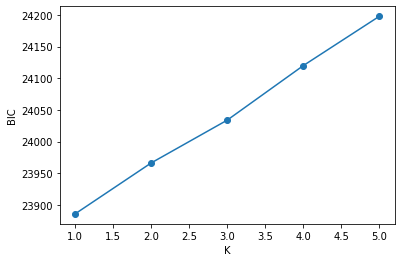

In [15]:
#@title GMM algorithm on Z
BICs = []
Ks= []
for k in range(1,6):
  Ks.append(k)
  N,d = Z.shape
  centroids=initialization(Z,k)
  z, Pi, Mu, Sigma = GMM_fit(Z,k,centroids)
  log_ell_hat = log_likelihood(Z, k, Pi, Mu, Sigma)
  bic = BIC(k,d,N,log_ell_hat)
  BICs.append(bic)


fig, ax = plt.subplots()
ax.scatter(Ks, BICs)
ax.plot(Ks, BICs)
ylabel('BIC')
xlabel('K')
plt.show()


In [16]:
#@title Opening y_train to find majority cluster using bincount to count the number of occurrences of y value at given z weight from above.
traincount = bincount(z)
print('The array of occurances in GMM is', traincount)

for i in range(len(traincount)):

  traincounted_bin_index_0 = len(where(z==0)[0])
  traincounted_bin_index_1 = len(where(z==1)[0])
  traincounted_bin_index_2 = len(where(z==2)[0])
  traincounted_bin_index_3 = len(where(z==3)[0])
print('Number in GMM clusters of Colin  Powell ' , traincounted_bin_index_0)
print('Number in GMM clusters of Donald Rumsfeld ', traincounted_bin_index_1)
print('Number in GMM clusters of George W. Bush ', traincounted_bin_index_2)
print('Number in GMM clusters of Tony Blair ', traincounted_bin_index_3)

The array of occurances in GMM is [203 437  30  63  40]
Number in GMM clusters of Colin  Powell  203
Number in GMM clusters of Donald Rumsfeld  437
Number in GMM clusters of George W. Bush  30
Number in GMM clusters of Tony Blair  63


738.7413189528636
0.0
Number of iteration is  2
1609.3854659109518
131.97147407963595
99.22022247731076
61.05528713097374
37.59121166602206
24.994579594406645
18.2139951006693
14.196269584885394
11.498339012188843
9.621021561227499
8.42530943256696
7.959421265083071
8.315943555157384
9.410569897513636
10.92017221246752
12.45812569457231
13.764689427297075
14.777495952485326
15.562635038337973
16.201435284370145
16.7291727634986
17.13205020921351
17.371226210860872
17.40792855780078
17.21630301690037
16.785176140071396
16.118032049883016
15.237091303483941
14.188212660523469
13.03858884294304
11.864024655628718
10.731713238296603
9.687898234604916
8.755058167172232
7.936602024761661
7.224295943795033
6.604781570294756
6.063821435856478
5.58844719992252
5.1677184079331555
4.792748620854058
4.4564303487608035
4.153088199777361
3.8781601698706294
3.6279385411831315
3.3993712576113224
3.1899138257954704
2.9974199191317608
2.8200603626891674
2.6562625079486115
2.504664172289792
2.36407802936

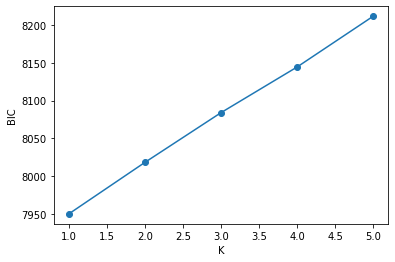

In [17]:
#@title To test GMM performance on Ztest.
BICs = []
Ks= []
for k in range(1,6):
  Ks.append(k)
  N,d = Ztest.shape
  centroids=initialization(Ztest,k)
  z, Pi, Mu, Sigma = GMM_fit(Ztest,k,centroids)
  log_ell_hat = log_likelihood(Ztest, k, Pi, Mu, Sigma)
  bic = BIC(k,d,N,log_ell_hat)
  BICs.append(bic)

fig, ax = plt.subplots()
ax.scatter(Ks, BICs)
ax.plot(Ks, BICs)
ylabel('BIC')
xlabel('K')
plt.show()


In [18]:
#@title Opening y_test to find majority cluster using bincount to count the number of occurrences of y value at given z weight from above.
testcount = bincount(z)
print('The array of occurances in GMM is', testcount)

for i in range(len(testcount)):

  counted_bin_index_0 = len(where(z==0)[0])
  counted_bin_index_1 = len(where(z==1)[0])
  counted_bin_index_2 = len(where(z==2)[0])
  counted_bin_index_3 = len(where(z==3)[0])
print('Number in GMM clusters of Colin  Powell ' , counted_bin_index_0)
print('Number in GMM clusters of Donald Rumsfeld ', counted_bin_index_1)
print('Number in GMM clusters of George W. Bush ', counted_bin_index_2)
print('Number in GMM clusters of Tony Blair ', counted_bin_index_3)

The array of occurances in GMM is [155  11  22  14  56]
Number in GMM clusters of Colin  Powell  155
Number in GMM clusters of Donald Rumsfeld  11
Number in GMM clusters of George W. Bush  22
Number in GMM clusters of Tony Blair  14


In [19]:
#@title Performing K-means algorithm on each person, replacing each row of the matrix X value by its closest centroid value on the training set with  K=4,8,16,.. 36.

def mykmeans(X, K, max_iter=500):
  # step 0
  centroids = X.copy()
  random.shuffle(centroids)
  centroids = centroids[:K]
  
  distortion_list = []
  for i in range(max_iter):
    # step 1
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    distortion_list.append(sum(np.min(distances, axis=0)))
    closest   = argmin(distances, axis=0)
    centroids_old = centroids
    # step 2
    centroids = array([X[closest==k].mean(axis=0) for k in range(K)])
    # step 3
    if sum(centroids-centroids_old) == 0.:
     # print('Number of iteration is ', i+1)
      break

  return centroids, closest, distortion_list


In [20]:
#@title Opening y_train to find majority clusters of K-means.
n_clusters = [1,2,3,4]
bincount = (y_train)
#print('Number of array occurances in y_train' , bincount) #number of occurances in y_train
for j in range(len(n_clusters)):
  K=n_clusters[j]
  centroids, closest, distortion_list=mykmeans(Xtrain, K, max_iter=500)  
  bincount = (closest)
  print('The number of occurances in the 4 K-means clusters is ', bincount)
  counted_index_0 = len(where(closest==0)[0])
  counted_index_1 = len(where(closest==1)[0])
  counted_index_2 = len(where(closest==2)[0])
  counted_index_3 = len(where(closest==3)[0])
print('Number in Kmeans clusters of Colin  Powell ' , counted_index_0)
print('Number in Kmeans clusters of Donald Rumsfeld ', counted_index_1)
print('Number in Kmeans clusters of George W. Bush ', counted_index_2)
print('Number in Kmeans clusters of Tony Blair ', counted_index_3)

The number of occurances in the 4 K-means clusters is  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

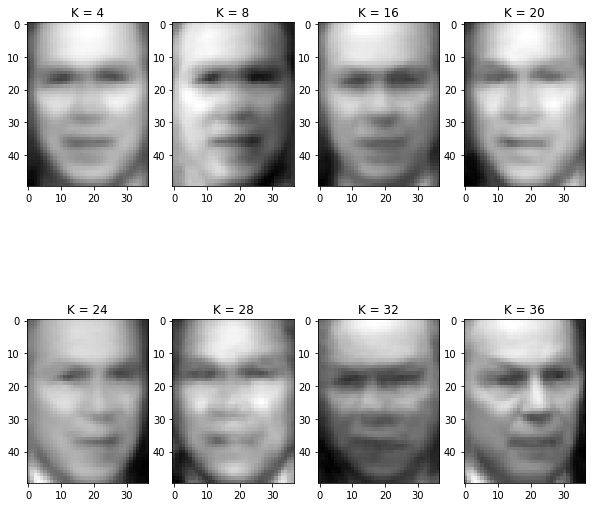

In [21]:
#@title Identifying patterns of clusters on training set images of Colin Powell.  
n_clusters = [4, 8, 16, 20 , 24, 28 , 32,36]
fig, axs = plt.subplots(2, 4,figsize=(10,10))
axs = axs.ravel()
for j in range(8):
  K=n_clusters[j]
  index = where(y_train==0)[0]
  centroids, closest, distortion_list=mykmeans(Xtrain, K, max_iter=500)  
  X_compress = centroids[closest]
  X_compress = reshape(X_compress, (773, 50, 37))
  axs[j].imshow(X_compress[index[j]], cmap=pyplot.get_cmap('gray'))
  #axs[j].imshow(X_compress[j], cmap=pyplot.get_cmap('gray'))
  axs[j].title.set_text(f'K = {K}')

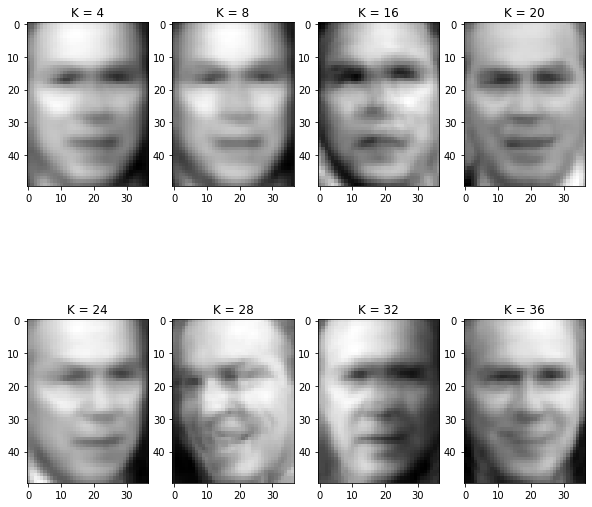

In [22]:
#@title Identifying patterns of clusters on training set images of Donald Rumsfeld.
n_clusters = [4, 8, 16, 20 , 24, 28 , 32,36]
fig, axs = plt.subplots(2, 4,figsize=(10,10))
axs = axs.ravel()
for j in range(8):
  K=n_clusters[j]
  index = where(y_train==1)[0]
  centroids, closest, distortion_list=mykmeans(Xtrain, K, max_iter=500)  
  X_compress = centroids[closest]
  X_compress = reshape(X_compress, (773, 50, 37))
  axs[j].imshow(X_compress[index[j]], cmap=pyplot.get_cmap('gray'))
  #axs[j].imshow(X_compress[j], cmap=pyplot.get_cmap('gray'))
  axs[j].title.set_text(f'K = {K}')

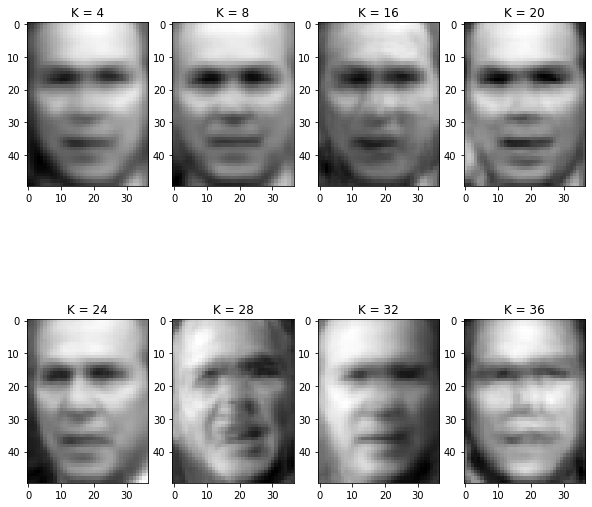

In [23]:
#@title Identifying patterns of clusters on training set images of George W Bush.
n_clusters = [4, 8, 16, 20 , 24, 28 , 32,36]
fig, axs = plt.subplots(2, 4,figsize=(10,10))
axs = axs.ravel()
for j in range(8):
  K=n_clusters[j]
  index = where(y_train==2)[0]
  centroids, closest, distortion_list=mykmeans(Xtrain, K, max_iter=500)  
  X_compress = centroids[closest]
  X_compress = reshape(X_compress, (773, 50, 37))
  axs[j].imshow(X_compress[index[j]], cmap=pyplot.get_cmap('gray'))
  #axs[j].imshow(X_compress[j], cmap=pyplot.get_cmap('gray'))
  axs[j].title.set_text(f'K = {K}')

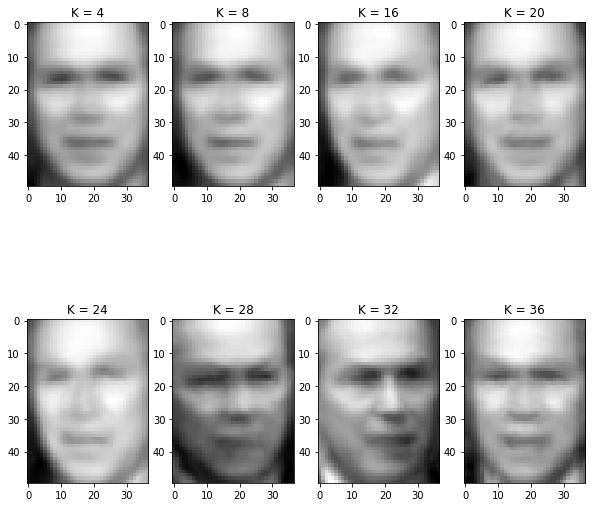

In [24]:
#@title Identifying patterns of clusters on training set images of Tony Blair.
n_clusters = [4, 8, 16, 20 , 24, 28 , 32,36]
fig, axs = plt.subplots(2, 4,figsize=(10,10))
axs = axs.ravel()
for j in range(8):
  K=n_clusters[j]
  index = where(y_train==3)[0]
  centroids, closest, distortion_list=mykmeans(Xtrain, K, max_iter=500)  
  X_compress = centroids[closest]
  X_compress = reshape(X_compress, (773, 50, 37))
  axs[j].imshow(X_compress[index[j]], cmap=pyplot.get_cmap('gray'))
  #axs[j].imshow(X_compress[j], cmap=pyplot.get_cmap('gray'))
  axs[j].title.set_text(f'K = {K}')

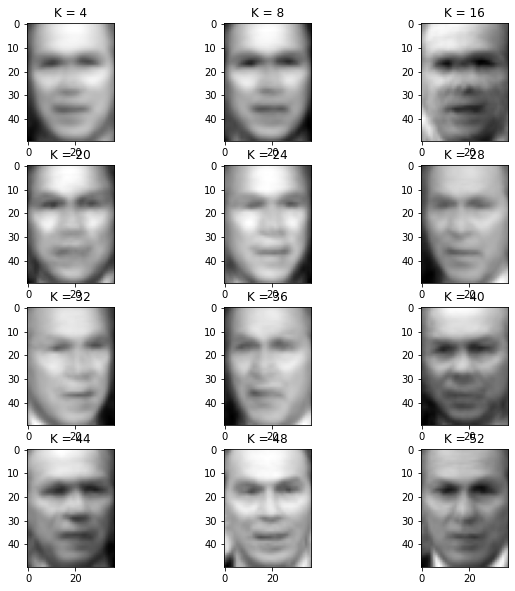

In [25]:
#@title Identifying patterns of clusters on training set images between Colin Powell and Donald Rumsfeld.
n_clusters = [4, 8, 16, 20 , 24, 28 , 32,36,40,44,48,52]
fig, axs = plt.subplots(4, 3,figsize=(10,10))
axs = axs.ravel()
for j in range(12):
  K=n_clusters[j]
  index = where(y_train<=1)[0]
  centroids, closest, distortion_list=mykmeans(Xtrain, K, max_iter=500)  
  X_compress = centroids[closest]
  X_compress = reshape(X_compress, (773, 50, 37))
  axs[j].imshow(X_compress[index[j]], cmap=pyplot.get_cmap('gray'))
  #axs[j].imshow(X_compress[j], cmap=pyplot.get_cmap('gray'))
  axs[j].title.set_text(f'K = {K}')

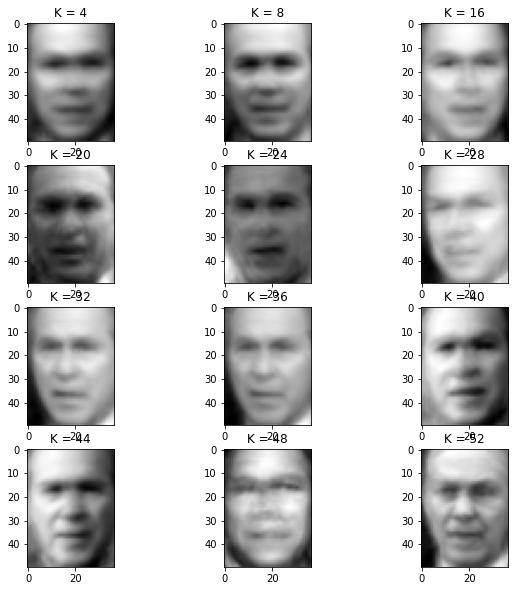

In [26]:
#@title Identifying patterns of clusters on training set images on George W Bush and Tony Blair.
n_clusters = [4, 8, 16, 20 , 24, 28 , 32,36,40,44,48,52]
fig, axs = plt.subplots(4, 3,figsize=(10,10))
axs = axs.ravel()
for j in range(12):
  K=n_clusters[j]
  index = where(y_train>=2)[0]
  centroids, closest, distortion_list=mykmeans(Xtrain, K, max_iter=500)  
  X_compress = centroids[closest]
  X_compress = reshape(X_compress, (773, 50, 37))
  axs[j].imshow(X_compress[index[j]], cmap=pyplot.get_cmap('gray'))
  #axs[j].imshow(X_compress[j], cmap=pyplot.get_cmap('gray'))
  axs[j].title.set_text(f'K = {K}')

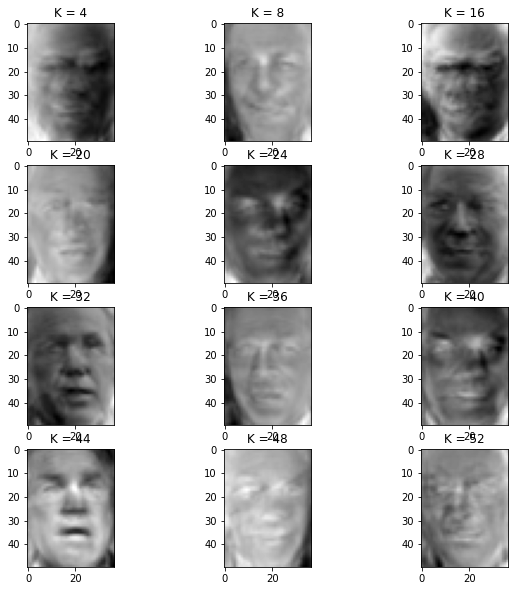

In [27]:
#@title Identifying patterns of clusters on testing set images of Colin Powell and Donald Rumsfeld.
n_clusters = [4, 8, 16, 20 , 24, 28 , 32,36,40,44,48,52]
fig, axs = plt.subplots(4, 3,figsize=(10,10))
axs = axs.ravel()
for j in range(12):
  K=n_clusters[j]
  index = where(y_test<=1)[0]
  centroids, closest, distortion_list=mykmeans(Xtest, K, max_iter=500)  
  X_compress = centroids[closest]
  X_compress = reshape(X_compress, (258, 50, 37))
  axs[j].imshow(X_compress[index[j]], cmap=pyplot.get_cmap('gray'))
  #axs[j].imshow(X_compress[j], cmap=pyplot.get_cmap('gray'))
  axs[j].title.set_text(f'K = {K}')

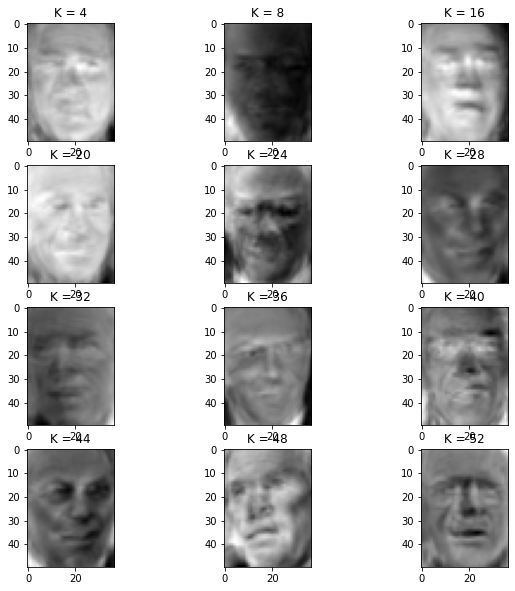

In [28]:
#@title Identifying patterns of clusters on testing set images of George W Bush and Tony Blair.
n_clusters = [4, 8, 16, 20 , 24, 28 , 32,36,40,44,48,52]
fig, axs = plt.subplots(4, 3,figsize=(10,10))
axs = axs.ravel()
for j in range(12):
  K=n_clusters[j]
  index = where(y_test>=2)[0]
  centroids, closest, distortion_list=mykmeans(Xtest, K, max_iter=500)  
  X_compress = centroids[closest]
  X_compress = reshape(X_compress, (258, 50, 37))
  axs[j].imshow(X_compress[index[j]], cmap=pyplot.get_cmap('gray'))
  #axs[j].imshow(X_compress[j], cmap=pyplot.get_cmap('gray'))
  axs[j].title.set_text(f'K = {K}')

# **Your Answer:**

1. When GMM is run on training set and the testing set, refer to clustering numbers in that that section.

2. When Kmeans algorithm is run on the training set, Cluster 1 had only Colin Powell as majority. Cluster 2 was a mixture of Colin Powell and Donald Rumsfeld. Cluster 3 there were all three faces: C. Powell, D. Rumsfeld and George W Bush. Cluster 4 was the only cluster that had majority with Tony Blair.

